# Import libraries

In [ ]:
import os
from os import listdir # os module help for work with file system
import numpy as np # for math+optmised work on arrays

# imports from tensorflow for deep learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, multiply, Lambda, add, Activation
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import *
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt # for plotting
%matplotlib inline
# for keeping the plot inside jupyter notebook

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix # metrics to compare model results
from sklearn.model_selection import KFold

import natsort # it may need to be installed by 'pip install natsort'

import datetime
now = datetime.datetime.now

# Load the images

In [ ]:
# Directory with images and ground truths
# Directory with salient masks, images, and ground truths
path_imgs = "../UNET/Unet_data/images/"
path_masks = "../UNET/Unet_data/masks/"

imagesList = listdir(path_imgs)

# Sort the images in ascending order
imgList=natsort.natsorted(imagesList)

# Introduce parameters
img_row = 256
img_col = 256
img_chan = 1
epochnum = 10
batchnum = 10
input_size = (img_row, img_col, img_chan)

num_imgs = len(imgList)
print("Number of images:", num_imgs)

Number of images: 501


In [ ]:
# Load the images
def img_load(dir_path, imgs_list, imgs_array):
    for i in range(num_imgs):
        if imgs_list[i][-4:] !=".png":
            continue
        tmp_img = image.load_img(os.path.join(dir_path, imgs_list[i]), target_size=(img_row, img_col, img_chan))
        img = image.img_to_array(tmp_img)
        imgs_array[i] = img[:,:,0]/255.0

    # Expand the dimensions of the arrays
    imgs_array = np.expand_dims(imgs_array, axis=3)
    return imgs_array

def mask_load(dir_path, imgs_list, imgs_array):
    for i in range(num_imgs):
        if imgs_list[i][-4:] !=".png":
            continue
        tmp_img = image.load_img(os.path.join(dir_path, imgs_list[i][:-4]+"_mask.png"), target_size=(img_row, img_col, img_chan))
        img = image.img_to_array(tmp_img)
        imgs_array[i] = img[:,:,0]/255.0

    # Expand the dimensions of the arrays
    imgs_array = np.expand_dims(imgs_array, axis=3)
    return imgs_array

# Initialize the arrays
imgs = np.zeros((num_imgs, img_row, img_col))
masks = np.zeros_like(imgs)

imgs = img_load(path_imgs, imgList, imgs)
masks = mask_load(path_masks, imgList, masks)

print("Images", imgs.shape)
print("Masks", masks.shape)

Images (501, 256, 256, 1)
Masks (501, 256, 256, 1)


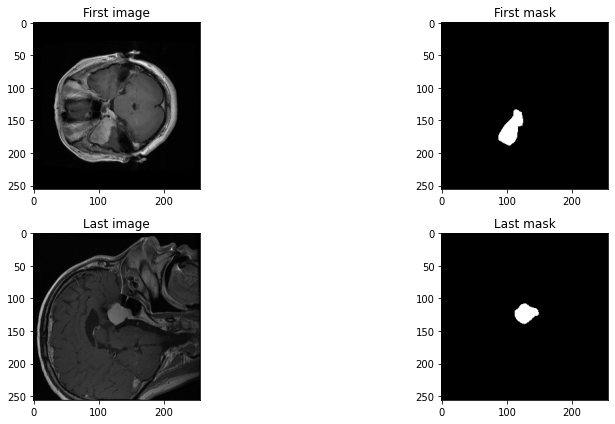

In [ ]:
# Plot the first and last images
plt.figure(figsize = (14,6))
plt.subplot(221)
plt.imshow(np.squeeze(imgs[0]), cmap = "gray")
plt.title('First image')
plt.subplot(222)
plt.imshow(np.squeeze(masks[0]), cmap = "gray")
plt.title('First mask')
plt.subplot(223)
plt.imshow(np.squeeze(imgs[-5]), cmap = "gray")
plt.title('Last image')
plt.subplot(224)
plt.imshow(np.squeeze(masks[-5]), cmap = "gray")
plt.title('Last mask')
plt.tight_layout()
plt.show()

# Performance metrics

In [ ]:
# Define loss and performance metrics
# Partially from Abraham and Khan (2019) - A Novel Focal Tversly Loss Function for Lesion Segmentation

# Dice score coefficient and Dice loss
def dsc(y_true, y_pred):
    smooth = 1.
    # masks
    y_true_fm = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_fm * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_fm) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

# Performance metrics: Dice score coefficient, IOU, recall, sensitivity
def auc(y_true, y_pred):
    y_pred_pos = np.round(np.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = np.round(np.clip(y_true, 0, 1)) # ground truth
    y_neg = 1 - y_pos
    tp = np.sum(y_pos * y_pred_pos)
    tn = np.sum(y_neg * y_pred_neg)
    fp = np.sum(y_neg * y_pred_pos)
    fn = np.sum(y_pos * y_pred_neg)
    tpr = (tp + K.epsilon()) / (tp + fn + K.epsilon()) #recall
    tnr = (tn + K.epsilon()) / (tn + fp + K.epsilon())
    prec = (tp + K.epsilon()) / (tp + fp + K.epsilon()) #precision
    iou = (tp + K.epsilon()) / (tp + fn + fp + K.epsilon()) #intersection over union
    dsc = (2*tp + K.epsilon()) / (2*tp + fn + fp + K.epsilon()) #dice score
    return [dsc, iou, tpr, prec]

In [ ]:
# Convolutional block for UNet
def ConvBlock(in_fmaps, num_fmaps):
    # Inputs: feature maps for UNet, number of output feature maps
    conv1 = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(in_fmaps)
    conv_out = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(conv1)
    return conv_out

# Network

In [ ]:
# Build the model
def Network():

    input = Input(shape=input_size)

    conv1 = ConvBlock(input, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = ConvBlock(pool1, 32)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = ConvBlock(pool2, 64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = ConvBlock(pool3, 64)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = ConvBlock(pool4, 128)

    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = ConvBlock(up6, 64)

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = ConvBlock(up7, 64)

    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = ConvBlock(up8, 32)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = ConvBlock(up9, 32)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs = input, outputs = conv10)

    return model

# Training

In [ ]:
 from sklearn.model_selection import train_test_split

In [ ]:
np.arange(0,499)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
train, test = train_test_split(np.arange(0,499), test_size=0.15, random_state=42)

In [ ]:
# Define  the model
model = Network()
print("Model Start")

Model Start


In [ ]:
# Split into train and test sets
imgs_train = imgs[train]
masks_train = masks[train]
imgs_test = imgs[test]
masks_test = masks[test]
print("Images Loaded")

Images Loaded


In [ ]:
# Compile and fit the  model
model.compile(optimizer = Adam(lr = 0.0001), loss = dice_loss, metrics = [dsc])
batchnum = 30
epochnum = 5
t = now()
callbacks = [EarlyStopping(monitor='val_loss', patience = 5)]
print("Fit model on training data")
history = model.fit(imgs_train, masks_train, validation_split=0.15, batch_size=batchnum,
                    epochs=epochnum, verbose=1, callbacks=callbacks)
print(history)
print('Training time: %s' % (now() - t))

Fit model on training data


c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
12/12 [==============================] - 204s 17s/step - loss: 0.9667 - dsc: 0.0333 - val_loss: 0.9654 - val_dsc: 0.0306
Epoch 2/5
12/12 [==============================] - 184s 15s/step - loss: 0.9662 - dsc: 0.0338 - val_loss: 0.9648 - val_dsc: 0.0311
Epoch 3/5
12/12 [==============================] - 183s 15s/step - loss: 0.9655 - dsc: 0.0345 - val_loss: 0.9638 - val_dsc: 0.0320
Epoch 4/5
12/12 [==============================] - 180s 15s/step - loss: 0.9641 - dsc: 0.0359 - val_loss: 0.9619 - val_dsc: 0.0336
Epoch 5/5
12/12 [==============================] - 173s 14s/step - loss: 0.9614 - dsc: 0.0386 - val_loss: 0.9575 - val_dsc: 0.0375
Training time: 0:15:24.680367


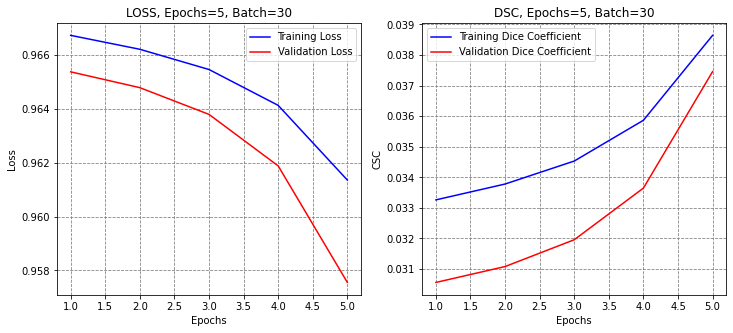

In [ ]:
# Plot the loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['dsc']
val_acc = history.history['val_dsc']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.figure(figsize = (12,5))
plt.subplot(121)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS, Epochs={}, Batch={}'.format(epochnum, batchnum))
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(epochsn, acc, 'b', label='Training Dice Coefficient')
plt.plot(epochsn, val_acc, 'r', label='Validation Dice Coefficient')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('DSC, Epochs={}, Batch={}'.format(epochnum, batchnum))
plt.xlabel('Epochs')
plt.ylabel('CSC')
plt.show()

In [ ]:
# Make predictions
t = now()
preds = model.predict(imgs_test)
print('Testing time: %s' % (now() - t))

3/3 [==============================] - 7s 2s/step
Testing time: 0:00:07.127041


In [ ]:
# Evaluate model
num_test = len(imgs_test)

In [ ]:
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(masks_test[i], preds[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,
        np.sum(iou_sc)/num_test,
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test ))

------------------------------
USING THRESHOLD 0.5

 DSC 		0.080 
 IOU 		0.043 
 Recall 	1.000 
 Precision	0.043


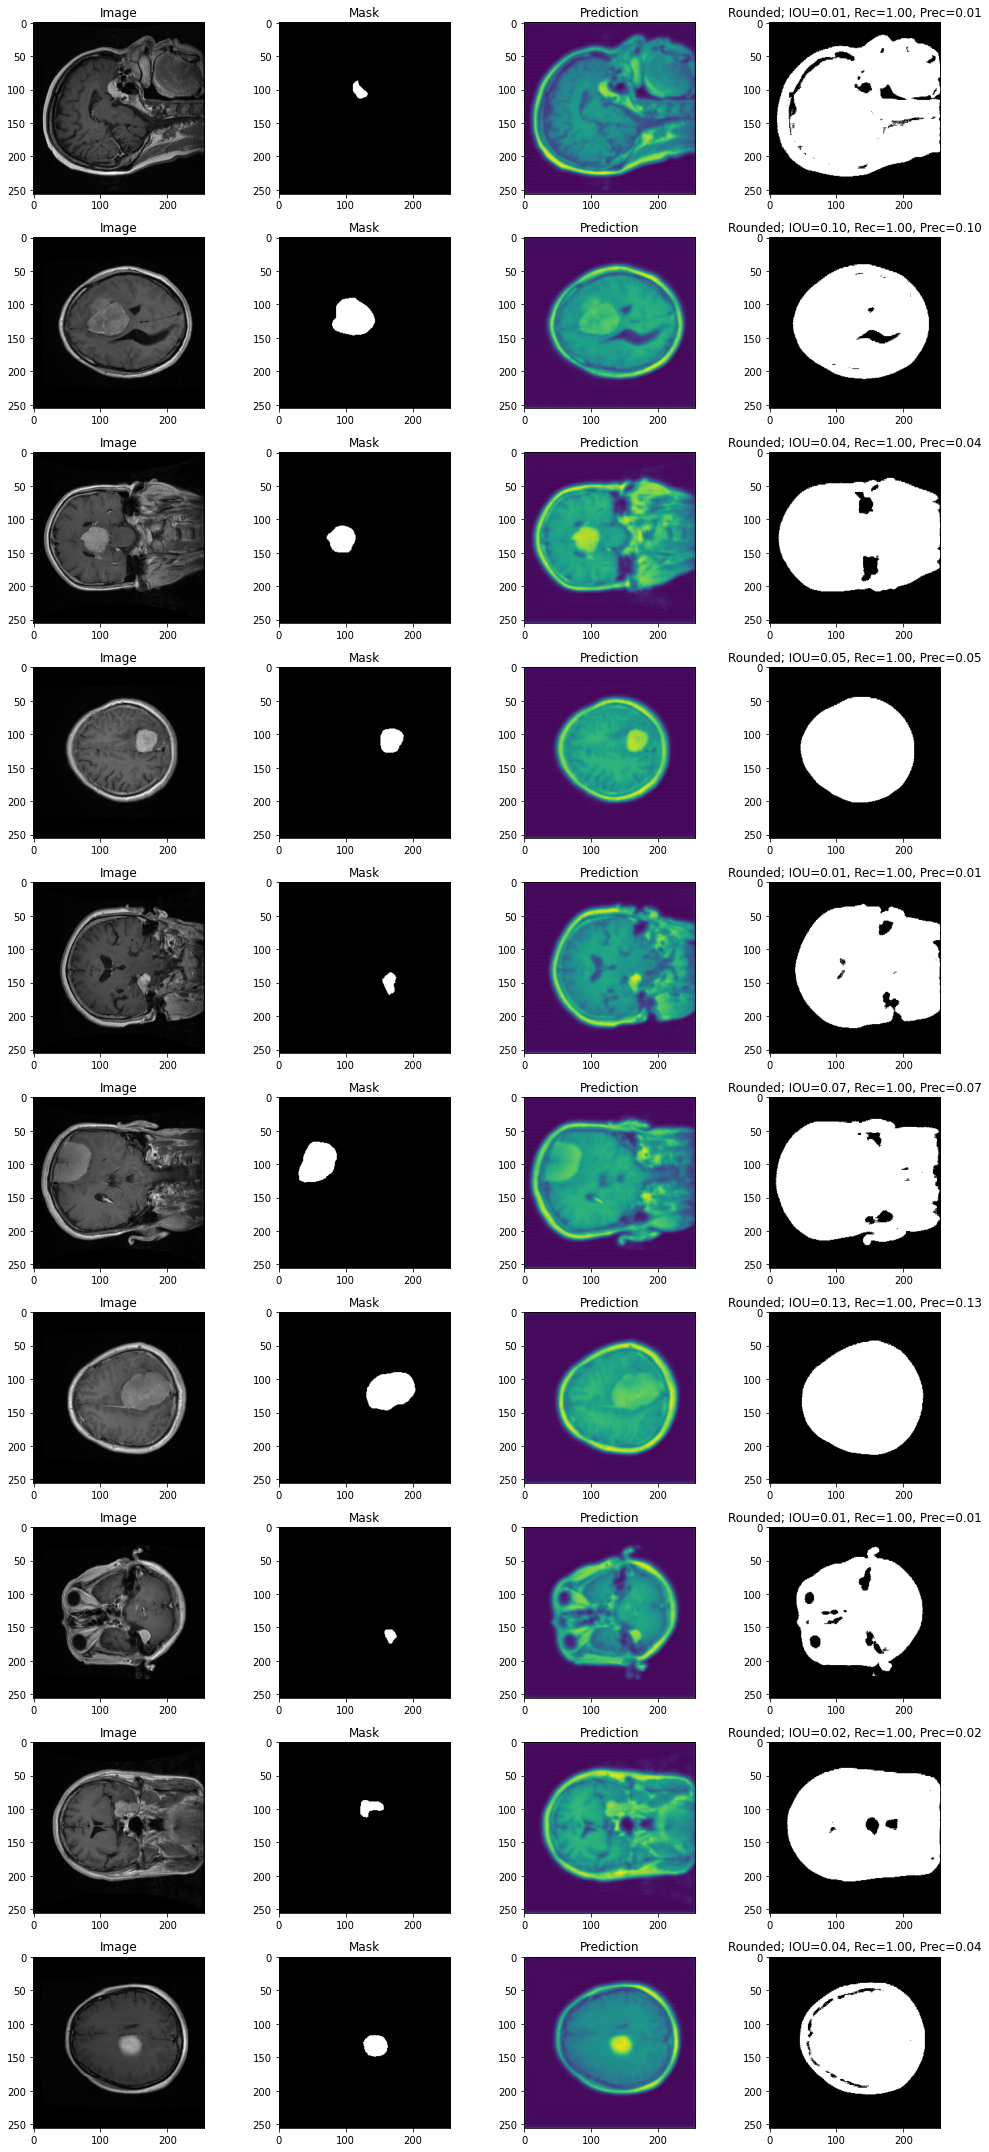

In [ ]:
# To plot a set of images with predicted masks uncomment these lines
num_disp = 10
j=1
plt.figure(figsize = (14,num_disp*3))
for i in range(num_disp):
    plt.subplot(num_disp,4,j)
    plt.imshow(np.squeeze(imgs_test[i]), cmap='gray')
    plt.title('Image')
    j +=1
    plt.subplot(num_disp,4,j)
    plt.imshow(np.squeeze(masks_test[i]),cmap='gray')
    plt.title('Mask')
    j +=1
    plt.subplot(num_disp,4,j)
    plt.imshow(np.squeeze(preds[i]))
    plt.title('Prediction')
    j +=1
    plt.subplot(num_disp,4,j)
    plt.imshow(np.squeeze(np.round(preds[i])), cmap='gray')
    plt.title('Rounded; IOU=%0.2f, Rec=%0.2f, Prec=%0.2f' %(iou_sc[i], rec_sc[i], prec_sc[i]))
    j +=1
plt.tight_layout()
plt.show()

In [ ]:

# Confusion matrix
confusion = confusion_matrix( masks_test.ravel(),preds.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Accuracy \t{0:^.3f}'.format(accuracy))

 Global Accuracy 	0.573


In [ ]:
# Save outputs
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy

# Display the Results

In [ ]:
{'Epochs Number': numepochs, 'Dice Score': dice_score, 'Recall (Sensitivity)': rec_score, 'Precision': prec_score, 'Global Accuracy': globacc_score}

{'Epochs Number': 5,
 'Dice Score': 0.08030849488573732,
 'Recall (Sensitivity)': 0.9999928122192276,
 'Precision': 0.04292654004187385,
 'Global Accuracy': 0.57264404296875}